In [1]:
import os, sys
sys.path.append('..')
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.cluster import cluster_trips
from utils.cluster import get_statistics

In [9]:
datadir = os.path.join('..', 'data')
outdir = os.path.join('..', 'figures')
pth = os.path.join(datadir, 'trip_clean.parquet')
df = gpd.read_parquet(pth); df

,medallion,hack_license,pickup,pickup_datetime,vendor_id,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,...,BoroName_pickup_,Shape_Leng_pickup_,Shape_Area_pickup_,dropoff,index_dropoff,BoroCode_dropoff,BoroName_dropoff,Shape_Leng_dropoff,Shape_Area_dropoff,euclidean_distance
0,6EE35E76FB48F9B79A337DDE55381126,16DA2E2A5B7CF561C21886460B636A31,POINT (9.98e+05 2.41e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:04:25,1,206,...,Manhattan,357180.674063,6.363981e+08,POINT (9.96e+05 2.39e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.526704
1,9400FEF51A4DE705BD4578E3AB86A318,A0C7F56B74AB6A80B8B602B8F46262A8,POINT (9.92e+05 2.17e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:05:23,4,310,...,Manhattan,357180.674063,6.363981e+08,POINT (9.96e+05 2.2e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.922924
2,2B131E11C91746501DB1E449ACFDDED5,2C24F168E6F6B8EC4A4D96E575C0EC40,POINT (1.02e+06 2.19e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:15:53,1,911,...,Queens,896934.880411,3.045058e+09,POINT (9.99e+05 2.17e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,4.512526
3,D6B1A78F308FDE278D231C220F83D2A5,931B3AE4A8931DD58BA3E42766889BEC,POINT (9.93e+05 2.17e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:16:43,1,944,...,Manhattan,357180.674063,6.363981e+08,POINT (1.01e+06 2.18e+05),4.0,4.0,Queens,896934.880411,3.045058e+09,2.873268
4,453B4DFA908932D761EF47FE919CDD72,A7B7AAEF95483779C50A7A0551EBD2E4,POINT (9.85e+05 2.01e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:08:29,1,505,...,Manhattan,357180.674063,6.363981e+08,POINT (9.89e+05 2.03e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.952522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526788,FA48B4171DF5DAD8991253F81E2BF0FE,B00DC87B11CCEBDABBF86DD1D6E2CD07,POINT (9.85e+05 2.07e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:58:30,1,74,...,Manhattan,357180.674063,6.363981e+08,POINT (9.85e+05 2.09e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.403466
1526789,1E268C16FEFBC4384CA90B84F8BDD060,1167EF28EEAC54FEDD1DBE1891B1855E,POINT (9.97e+05 2.23e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:59:34,1,130,...,Manhattan,357180.674063,6.363981e+08,POINT (9.96e+05 2.2e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.517157
1526790,68D4B2FDB737B3E4449B8E8FCBEB0CC2,AF905278ACE8A86E989F0B79414571A9,POINT (9.9e+05 2.05e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:59:59,1,138,...,Manhattan,357180.674063,6.363981e+08,POINT (9.89e+05 2.03e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.431326
1526791,D42076D7B45BCFBB8D544D765C2FB094,DC3A15804D7193B647BA71166CF161A8,POINT (9.98e+05 2.25e+05),2013-06-09 23:58:00,CMT,1,N,2013-06-09 23:59:36,1,92,...,Manhattan,357180.674063,6.363981e+08,POINT (1e+06 2.28e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.478341


## Hourly pickups trends

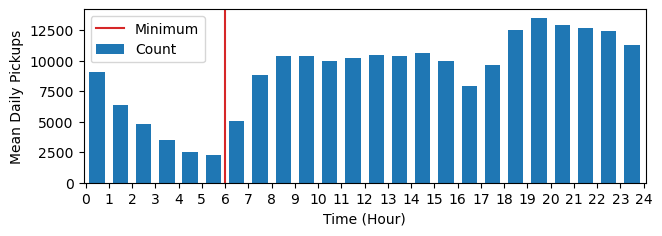

In [3]:
# find best start time for 24-hr windows
fig, ax = plt.subplots(1, 1, figsize = (7.25, 2.25))
pickup = df.pickup_datetime.dt.hour.value_counts().div(7).sort_index()
pickup.plot(kind = 'bar', width = .66, label = 'Count', ax = ax)
ax.axvline(pickup.idxmin() + .5, c = 'tab:red', label = 'Minimum')
xticks = np.arange(25)
ax.set_xticks(xticks - .5, xticks, rotation = 0)
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Mean Daily Pickups')
ax.legend()
plt.show()

## Cluster trips using windowed HDBSCAN
- Input: (x,y) values for pickup/dropoff + t (scaled; pickup only)
- Output: cluster labels for trips/passengers
- Windows: $\leq$ 24 hrs (split = 6 AM)

## Explore spatiotemporal tradeoffs

In [ ]:
min_cluster_size = 6                          # typical capacity of microtransit van
time_scale = np.arange(10, 61, 10)            # spatiotemporal knob (min / mi)
rmsd_xy = np.zeros((time_scale.size, 2))      # average RMS distance of pickups, dropoffs
std_t = np.zeros((time_scale.size, 2))        # average STD time of pickups, dropoffs
clus_size = np.zeros((time_scale.size, 2))    # fraction clustered, average cluster sizes

# loop over time scales
for i in range(time_scale.size):
    print('\n', time_scale[i], 'minutes / mile')

    # windowed HDBSCAN clustering
    df_i = cluster_trips(df, time_scale[i], min_cluster_size)
    
    # get summary statistics
    res_i = get_statistics(df_i)
    rmsd_xy[i, 0] = res_i['rmsd_xy0'].mean()
    rmsd_xy[i, 1] = res_i['rmsd_xy1'].mean()
    std_t[i, 0] = res_i['std_t0'].mean()
    std_t[i, 1] = res_i['std_t1'].mean()
    clus_size[i, 0] = res_i['frac_clus']
    clus_size[i, 1] = res_i['clus_size'].mean()

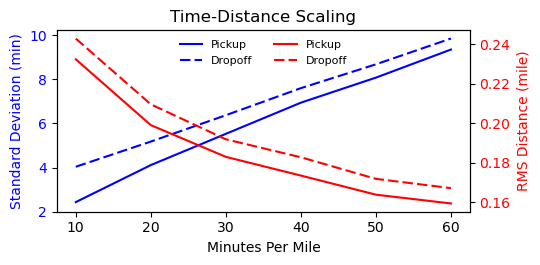

In [13]:
# average STD time of pickups, dropoffs
fig, ax = plt.subplots(1, 1, figsize = (5.5, 2.75))
ax.plot(time_scale, std_t[:, 0], c = 'b', ls = '-', label = 'Pickup')
ax.plot(time_scale, std_t[:, 1], c = 'b', ls = (0, (5, 2)), label = 'Dropoff')
ax.set_ylabel('Standard Deviation (min)', color = 'b')
ax.set_yticks(np.arange(2, 11, 2))
ax.tick_params('y', labelcolor = 'b')

# average RMS distance of pickups, dropoffs
ax0 = ax.twinx()
ax0.plot(time_scale, rmsd_xy[:, 0], c = 'r', ls = '-', label = 'Pickup')
ax0.plot(time_scale, rmsd_xy[:, 1], c = 'r', ls = (0, (5, 2)), label = 'Dropoff')
ax0.set_ylabel('RMS Distance (mile)', color = 'r')
ax0.tick_params('y', labelcolor = 'r')

# legend
lines = ax.get_lines() + ax0.get_lines()
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, ncols = 2, loc = 'upper center', fontsize = 8, frameon = False)

ax.set_title('Time-Distance Scaling')
ax.set_xlabel('Minutes Per Mile')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'scaling.svg'))

# # percent of passengers clustered
# ax[1].plot(time_scale, clus_size[:, 0] * 100, c = 'purple')
# ax[1].set_ylabel('Clustered (%)', color = 'purple')
# ax[1].tick_params('y', labelcolor = 'purple')

# # average passengers per cluster
# ax1 = ax[1].twinx()
# ax1.plot(time_scale, clus_size[:, 1], c = 'g')
# ax1.set_ylabel('Passengers (avg)', color = 'g')
# ax1.tick_params('y', labelcolor = 'g')
# ax1.set_yticks(np.arange(12, 14, .5))

## Final iterative HDBSCAN clustering

In [ ]:
min_cluster_size = 6   # relax by one at each iteration
time_scale = 25        # spatiotemporal coherence scale

df_clus = df.copy(); df_clus['cluster_label'] = -1
for i in range(min_cluster_size - 1):
    df_i = df_clus.loc[df_clus.cluster_label == -1]
    print('\nIteration', i, '— min_cluster_size =',
          min_cluster_size, 'and n =', df_i.shape[0])
    df_i = cluster_trips(df_i, time_scale, min_cluster_size, verbose = True)
    labels = df_i['cluster_label'].copy()
    labels[labels > -1] += df_clus.cluster_label.max() + 1
    df_clus.loc[df_i.index, 'cluster_label'] = labels
    min_cluster_size -= 1


Iteration 0 — min_cluster_size = 6 and n = 1526793
0 — 2013-06-03 00:00:00 - 2013-06-03 05:59:00
1 — 2013-06-03 06:00:00 - 2013-06-04 05:59:00
2 — 2013-06-04 06:00:00 - 2013-06-05 05:59:00
3 — 2013-06-05 06:00:00 - 2013-06-06 05:59:00
4 — 2013-06-06 06:00:00 - 2013-06-07 05:59:00
5 — 2013-06-07 06:00:00 - 2013-06-08 05:59:00
6 — 2013-06-08 06:00:00 - 2013-06-09 05:59:00
7 — 2013-06-09 06:00:00 - 2013-06-09 23:58:00

Iteration 1 — min_cluster_size = 5 and n = 1360458
0 — 2013-06-03 00:00:00 - 2013-06-03 05:59:00
1 — 2013-06-03 06:00:00 - 2013-06-04 05:59:00
2 — 2013-06-04 06:00:00 - 2013-06-05 05:59:00
3 — 2013-06-05 06:00:00 - 2013-06-06 05:59:00
4 — 2013-06-06 06:00:00 - 2013-06-07 05:59:00
5 — 2013-06-07 06:00:00 - 2013-06-08 05:59:00
6 — 2013-06-08 06:00:00 - 2013-06-09 05:59:00
7 — 2013-06-09 06:00:00 - 2013-06-09 23:58:00

Iteration 2 — min_cluster_size = 4 and n = 1112002
0 — 2013-06-03 00:00:00 - 2013-06-03 05:59:00
1 — 2013-06-03 06:00:00 - 2013-06-04 05:59:00
2 — 2013-06-04 0

In [31]:
df_clus

,medallion,hack_license,pickup,pickup_datetime,vendor_id,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,...,Shape_Leng_pickup_,Shape_Area_pickup_,dropoff,index_dropoff,BoroCode_dropoff,BoroName_dropoff,Shape_Leng_dropoff,Shape_Area_dropoff,euclidean_distance,cluster_label
0,6EE35E76FB48F9B79A337DDE55381126,16DA2E2A5B7CF561C21886460B636A31,POINT (9.98e+05 2.41e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:04:25,1,206,...,357180.674063,6.363981e+08,POINT (9.96e+05 2.39e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.526704,-1
1,9400FEF51A4DE705BD4578E3AB86A318,A0C7F56B74AB6A80B8B602B8F46262A8,POINT (9.92e+05 2.17e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:05:23,4,310,...,357180.674063,6.363981e+08,POINT (9.96e+05 2.2e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.922924,323
2,2B131E11C91746501DB1E449ACFDDED5,2C24F168E6F6B8EC4A4D96E575C0EC40,POINT (1.02e+06 2.19e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:15:53,1,911,...,896934.880411,3.045058e+09,POINT (9.99e+05 2.17e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,4.512526,164988
3,D6B1A78F308FDE278D231C220F83D2A5,931B3AE4A8931DD58BA3E42766889BEC,POINT (9.93e+05 2.17e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:16:43,1,944,...,357180.674063,6.363981e+08,POINT (1.01e+06 2.18e+05),4.0,4.0,Queens,896934.880411,3.045058e+09,2.873268,165276
4,453B4DFA908932D761EF47FE919CDD72,A7B7AAEF95483779C50A7A0551EBD2E4,POINT (9.85e+05 2.01e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:08:29,1,505,...,357180.674063,6.363981e+08,POINT (9.89e+05 2.03e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.952522,56154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526788,FA48B4171DF5DAD8991253F81E2BF0FE,B00DC87B11CCEBDABBF86DD1D6E2CD07,POINT (9.85e+05 2.07e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:58:30,1,74,...,357180.674063,6.363981e+08,POINT (9.85e+05 2.09e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.403466,-1
1526789,1E268C16FEFBC4384CA90B84F8BDD060,1167EF28EEAC54FEDD1DBE1891B1855E,POINT (9.97e+05 2.23e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:59:34,1,130,...,357180.674063,6.363981e+08,POINT (9.96e+05 2.2e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.517157,-1
1526790,68D4B2FDB737B3E4449B8E8FCBEB0CC2,AF905278ACE8A86E989F0B79414571A9,POINT (9.9e+05 2.05e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:59:59,1,138,...,357180.674063,6.363981e+08,POINT (9.89e+05 2.03e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.431326,162555
1526791,D42076D7B45BCFBB8D544D765C2FB094,DC3A15804D7193B647BA71166CF161A8,POINT (9.98e+05 2.25e+05),2013-06-09 23:58:00,CMT,1,N,2013-06-09 23:59:36,1,92,...,357180.674063,6.363981e+08,POINT (1e+06 2.28e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.478341,160924


## Compute statistics and visualilze results

In [ ]:
res = get_statistics(df_clus)

In [67]:
print('passengers clustered =', round(res['frac_clus'], 4) * 100, '%')

passengers clustered = 84.11 %


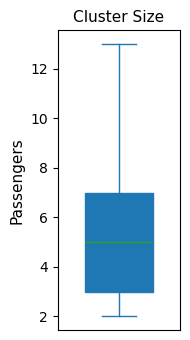

In [83]:
# plot passengers per cluster
fig, ax = plt.subplots(1, 1, figsize = (2, 3.5))
res['clus_size'].plot(
    kind = 'box',
    widths = .55,
    showfliers = False,
    patch_artist = True,
    ax = ax)
ax.set_xticks([])
ax.set_title('Cluster Size', size = 11)
ax.set_ylabel('Passengers', size = 11)
plt.tight_layout()
plt.show()

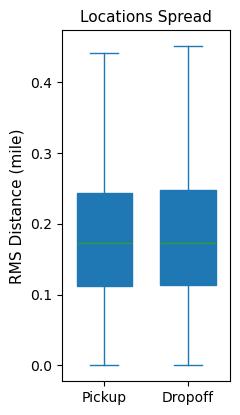

In [87]:
# plot RMS distance of pickups, dropoffs
fig, ax = plt.subplots(1, 1, figsize = (2.5, 4.25))
rmsd_xy01 = pd.concat((res['rmsd_xy0'], res['rmsd_xy1']), axis = 1)
rmsd_xy01.columns = ['Pickup', 'Dropoff']
rmsd_xy01.plot(
    kind = 'box',
    widths = .66,
    showfliers = False,
    patch_artist = True,
    ax = ax)
ax.set_title('Locations Spread', size = 11)
ax.set_ylabel('RMS Distance (mile)', size = 11)
plt.tight_layout()
plt.show()

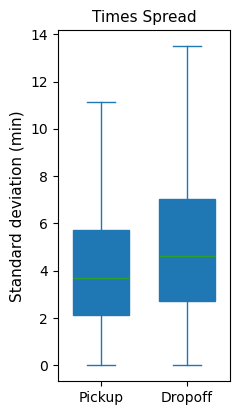

In [88]:
# plot STD time of pickups, dropoffs
fig, ax = plt.subplots(1, 1, figsize = (2.5, 4.25))
std_t01 = pd.concat((res['std_t0'], res['std_t1']), axis = 1)
std_t01.columns = ['Pickup', 'Dropoff']
std_t01.plot(
    kind = 'box',
    widths = .66,
    showfliers = False,
    patch_artist = True,
    ax = ax)
ax.set_title('Times Spread', size = 11)
ax.set_ylabel('Standard deviation (min)', size = 11)
plt.tight_layout()
plt.show()

In [90]:
df_clus.to_parquet(os.path.join(datadir, 'trip_cluster.parquet'))